# Predicting Positions of Soccer Players using Machine-Learning

In [1]:
import ast

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from playervectors import PlayerVectors
from playervectors.helpers import (
    ExtractPlayers,
    ExtractTeams,
    ExtractMinutesPlayed)

In [2]:
# Load event stream data
df_players = pd.read_csv('data/players.csv')
df_playerank = pd.read_csv('data/playerank.csv')
df_teams = pd.read_csv('data/teams.csv')
df_events = pd.read_csv('data/actions.csv')

In [3]:
# Normalize playing direction
df_events['start_x'] = (df_events['start_x'] / 105) * 100
df_events['start_y'] = (df_events['start_y'] / 68) * 100

df_events['start_x'] = 100 - df_events['start_x']
df_events['start_y'] = 100 - df_events['start_y']

In [4]:
# Extract a mapping of player_id's to selected attributes (first-name, last-name, team_id, position)
players = ExtractPlayers(df=df_players,
                         wy_id='wyId',
                         attributes=['firstName', 'lastName', 'currentTeamId', 'role'])

# Mapping {player_id -> played_minutes}
minutes_played = ExtractMinutesPlayed(df=df_playerank,
                                      column_player='playerId',
                                      column_minutes='minutesPlayed')

# Extracting Team Information
# Mapping {teamID -> [selected attributes e.g. TeamName, City, ...]}
teams = ExtractTeams(df=df_teams,
                     wy_id='wyId',
                     attributes=['name'])


# Mapping {teamID -> [list of playerIDs]}
teamID_to_playerIDs = {}

# Mapping {playerID -> Player Name}
playersID_to_name = {}

for playerID, attributes in players.items():
    first, last, teamID = attributes[0], str(attributes[1]), str(attributes[2])
    
    if teamID not in teamID_to_playerIDs:
        teamID_to_playerIDs[teamID] = [playerID]
    else:
        teamID_to_playerIDs[teamID].append(playerID)
    
    if playerID not in playersID_to_name:
        playersID_to_name[playerID] = f'{first} {last}'

In [5]:
positions = {player_id : attrib[3] for player_id, attrib in players.items()}
positions = {player_id: ast.literal_eval(positions[player_id])['name'] for player_id in positions}

In [6]:
pvs = PlayerVectors(grid=(50, 50),
                    sigma=4.0,
                    actions=['shot', 'cross', 'dribble', 'pass'],
                    components=[4, 4, 5, 5])

pvs.fit(df_events=df_events,
        minutes_played=minutes_played,
        player_names=playersID_to_name,
        verbose=True)

Action: shot	Shape of M: (2500, 3030)	Shape of W: (2500, 4)	Shape of H: (4, 3030)
Action: cross	Shape of M: (2500, 3030)	Shape of W: (2500, 4)	Shape of H: (4, 3030)
Action: dribble	Shape of M: (2500, 3030)	Shape of W: (2500, 5)	Shape of H: (5, 3030)
Action: pass	Shape of M: (2500, 3030)	Shape of W: (2500, 5)	Shape of H: (5, 3030)


In [7]:
del pvs.player_vectors[0]

# Compare Classification Models

#### Machine learning classification models:
* K Nearest Neighbour Classifier
* Suppor-Vector Classifier
* Decission Tree Classifier
* Random Forest Classifier
* Gradient Boosted Decission Tree Classifier
* Multilayer Perceptron

In [8]:
# Classifier names
names = [
    'KNN',
    'SVM',
    'Dec. Tree', 
    'Random Forest',
    'GBDT',
    'MLP'
]

# Classifiers
classifiers = [
    KNeighborsClassifier(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    MLPClassifier()
]

# Store accuracys
acc_train = []
acc_test = []

# Predictions
preds_train = []
preds_test = []

In [9]:
# Load data
X = [pvs.player_vectors[player_id] for player_id in pvs.player_vectors]
y = [positions[player_id] for player_id in pvs.player_vectors]

# Label encoding
le = LabelEncoder()
y_enc = le.fit_transform(y)

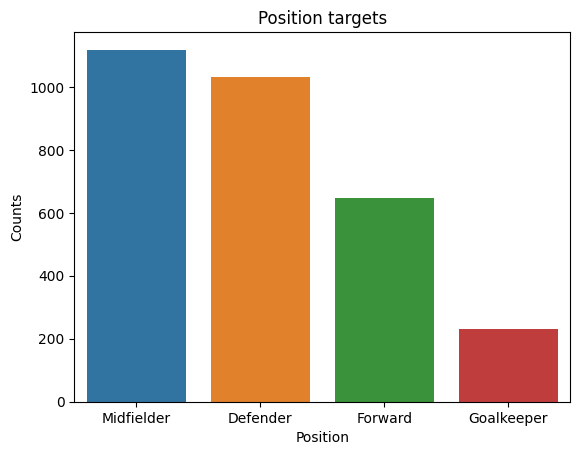

In [10]:
df_targets = pd.DataFrame({'Position': y})
df_targets = df_targets['Position'].value_counts().reset_index(name='Counts')

plt.title('Position targets')
sns.barplot(x='Position',
            y='Counts',
            data=df_targets,
            hue=list(df_targets['Position']))
plt.show()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, train_size=0.8)

In [12]:
print(f'X_train shape: {np.shape(X_train)}')
print(f'y_train shape: {np.shape(y_train)}')
print(f'X_test shape: {np.shape(X_test)}')
print(f'y_test shape: {np.shape(y_test)}')

X_train shape: (2423, 18)
y_train shape: (2423,)
X_test shape: (606, 18)
y_test shape: (606,)


In [13]:
for name, model in zip(names, classifiers):
    model.fit(X_train, y_train)
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)

    acc_train_score = accuracy_score(y_train, y_hat_train)
    acc_test_score = accuracy_score(y_test, y_hat_test)

    acc_train.append(acc_train_score)
    acc_test.append(acc_test_score)

    preds_train.append(y_hat_train)
    preds_test.append(y_hat_test)

In [14]:
df_accuracys = pd.DataFrame({'Classifier': names,
                         'accuracy_train': acc_train,
                         'accuracy_test': acc_test})
df_accuracys.head(len(names))

,Classifier,accuracy_train,accuracy_test
0,KNN,0.877837,0.795380
1,SVM,0.839868,0.826733
2,Dec. Tree,1.000000,0.795380
3,Random Forest,1.000000,0.854785
4,GBDT,0.945935,0.854785
5,MLP,0.852249,0.836634


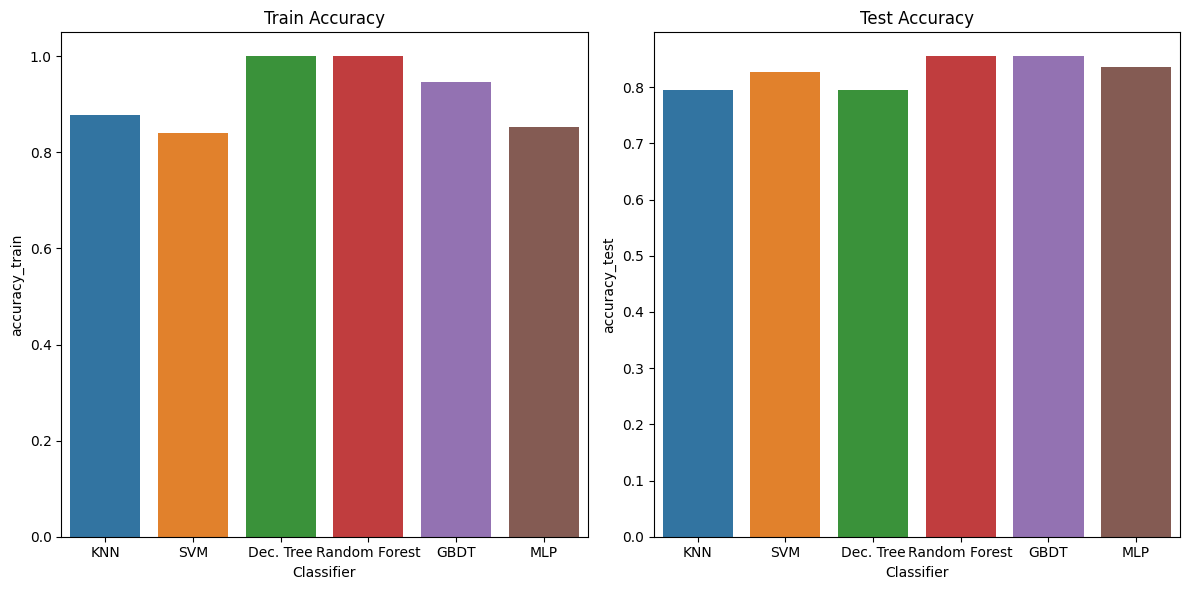

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

axes = axes.flatten()

axes[0].set_title('Train Accuracy')
sns.barplot(x='Classifier',
            y='accuracy_train',
            data=df_accuracys,
            hue=names,
            ax=axes[0])

axes[1].set_title('Test Accuracy')
sns.barplot(x='Classifier',
            y='accuracy_test',
            data=df_accuracys,
            hue=names,
            ax=axes[1]) 
plt.tight_layout()
plt.show()

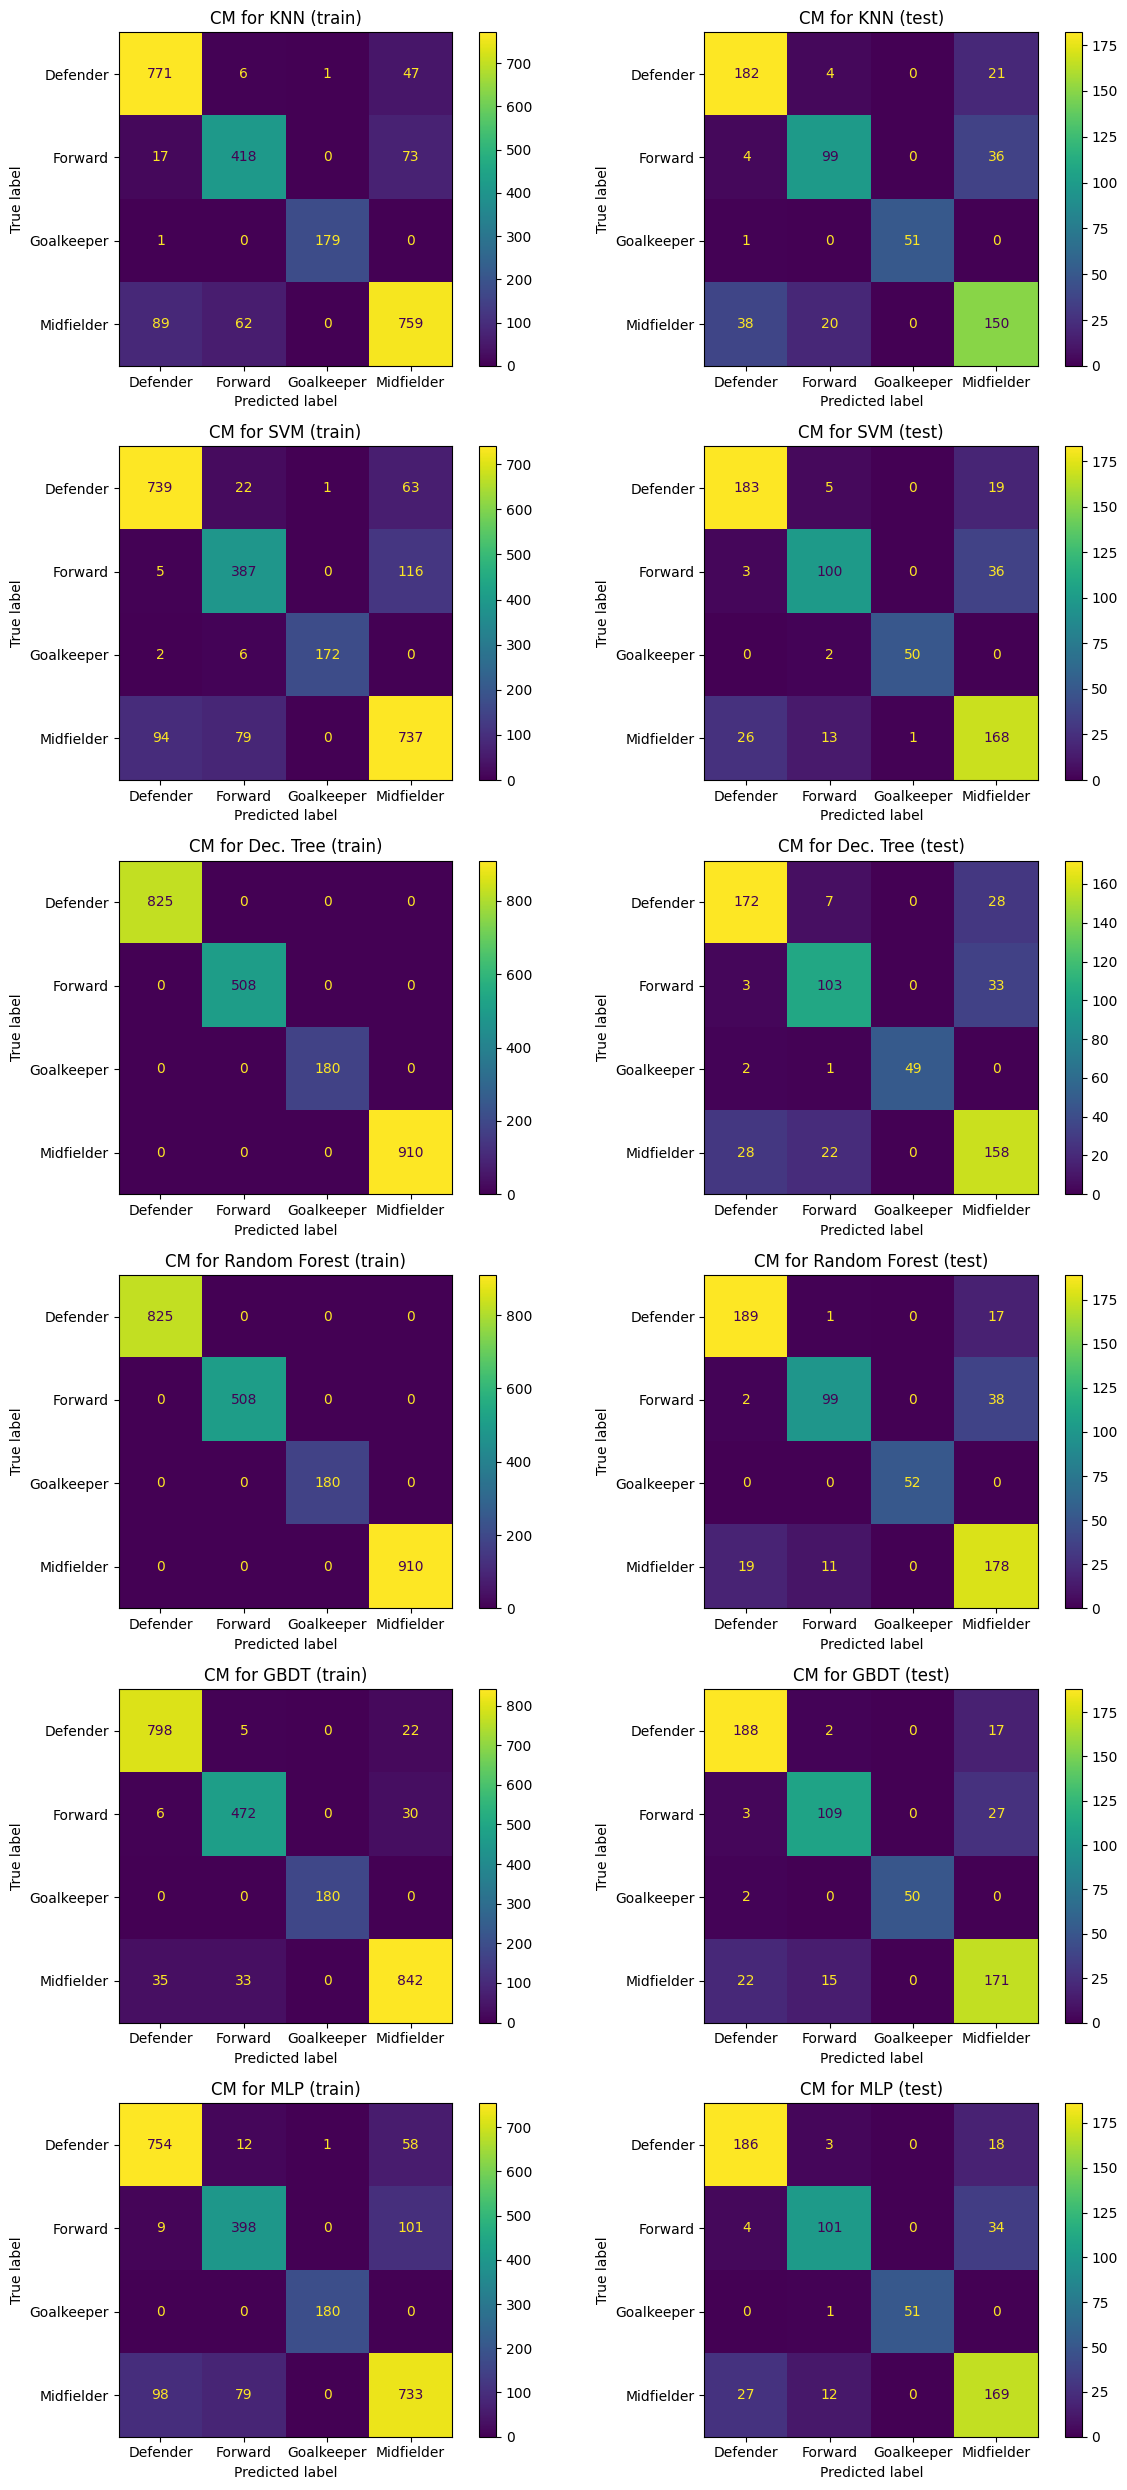

In [16]:
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(12, 25))

# flatten ax to make indexing easier
ax = ax.flatten()

for i, (name, y_pred_train, y_pred_test) in enumerate(zip(names, preds_train, preds_test)):
    # calculate confusion matrix train
    cm_train = confusion_matrix(y_train, y_pred_train)
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                                  display_labels=le.inverse_transform(list(range(0, 4))))

    # calculate confusion matrix test
    cm_test = confusion_matrix(y_test, y_pred_test)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                                  display_labels=le.inverse_transform(list(range(0, 4))))

    disp_train.plot(ax=ax[2*i])
    disp_test.plot(ax=ax[2*i+1])
    ax[2*i].set_title(f'CM for {name} (train)')
    ax[2*i+1].set_title(f'CM for {name} (test)')

plt.tight_layout()    
plt.show()